<a href="https://colab.research.google.com/github/willy-wagtail/Notes/blob/master/03_pytorch_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics # https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog
    from torchmetrics import Accuracy

from timeit import default_timer as timer 

from tqdm.auto import tqdm

import matplotlib.pyplot as plt

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 11.2 MB/s eta 0:00:00
PyTorch version: 2.0.0+cu118
torchvision version: 0.15.1+cu118


# Data Loading

In [2]:
train_data = datasets.FashionMNIST(
    root="data",          # where to download data to?
    train=True,           # training data or test data
    download=True,        # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels
)

100%|██████████| 26421880/26421880 [00:03<00:00, 8448642.82it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 144480.60it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2741996.47it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 24125449.15it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
test_data = datasets.FashionMNIST(
    root='data',
    train=False, # test data
    download=True,
    transform=ToTensor()
)

In [4]:
image, label = train_data[0]
image.shape, label

# [color_channels=1, height=28, width=28]
# color_channel=1 means grayscale

(torch.Size([1, 28, 28]), 9)

In [5]:
# how many samples
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [6]:
# what are the classes
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

# Visualisation

Image shape: torch.Size([1, 28, 28])


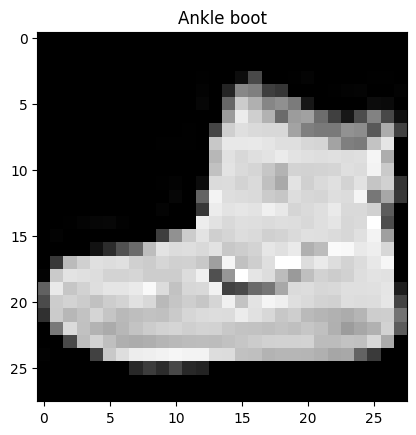

In [7]:
print(f"Image shape: {image.shape}")

# Shape [1, 28, 28] (colour channels, height, width) squeezed to [28, 28]
plt.imshow(image.squeeze(), cmap="gray") 
plt.title(class_names[label]);

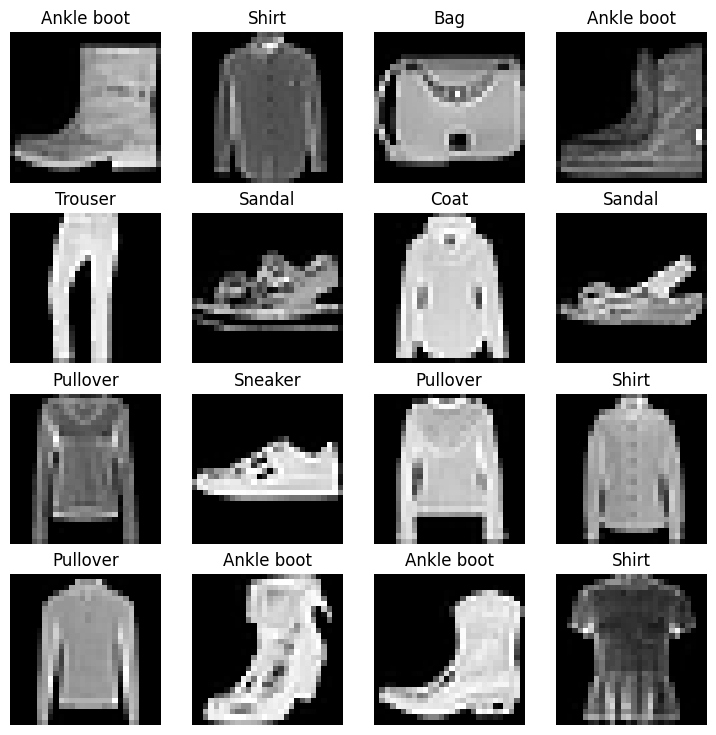

In [66]:
torch.manual_seed(42)

fig = plt.figure(figsize=(9,9))
rows, cols = 4,4

for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  image, label = train_data[random_idx]

  fig.add_subplot(rows, cols, i)
  plt.imshow(image.squeeze(), cmap='gray')
  plt.title(class_names[label])
  plt.axis(False); 

# Loading data into Model

In [9]:
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(
    train_data,            # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=True           # shuffle data every epoch?
)

test_dataloader = DataLoader(
    test_data,
    shuffle=False # Don't necessarily have to shuffle test data
)

In [10]:
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7eff88ef4d00>, <torch.utils.data.dataloader.DataLoader object at 0x7eff88ef6bc0>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 10000 batches of 32


In [11]:
# sneak peak inside train_dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch

(torch.Size([32, 1, 28, 28]),
 tensor([5, 1, 8, 1, 5, 2, 6, 7, 3, 5, 9, 5, 7, 5, 0, 4, 4, 4, 4, 6, 1, 8, 0, 1,
         9, 7, 8, 8, 3, 3, 7, 2]))

Image size: torch.Size([1, 28, 28])
Label: 6, label size: torch.Size([])


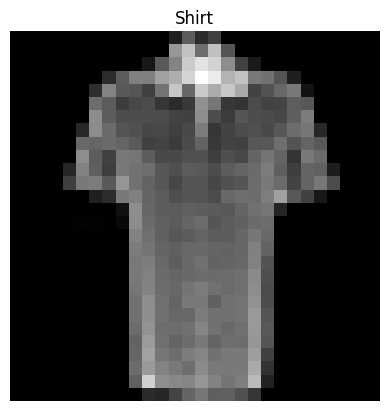

In [67]:
torch.manual_seed(42)

random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
image, label = train_features_batch[random_idx], train_labels_batch[random_idx]

plt.imshow(image.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis(False); 

print(f"Image size: {image.shape}")
print(f"Label: {label}, label size: {label.shape}")

# Model V0 - Linear

Run with CPU for fun and to compare with GPU later.

In [13]:
# Flatten an image sample using a nn model to create a feature vector
# [color_channels, height, width] -> [color_channels, height*width]

flatten_model = nn.Flatten()

x = train_features_batch[0]
output = flatten_model(x) # can do forward pass

x.shape, output.shape

(torch.Size([1, 28, 28]), torch.Size([1, 784]))

In [14]:
class FashionMNISTModelV0(nn.Module):
  def __init__(
      self, input_shape: int,
      hidden_units: int,
      output_shape: int
    ):
    super().__init__()

    self.layers = nn.Sequential(
        nn.Flatten(),  # create feature vector
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_shape)
    )

  def forward(self, x):
    return self.layers(x)

In [15]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(
    input_shape=784, # size of flattened feature vector
    hidden_units=10,
    output_shape=len(class_names)
)

# as an experiement, train on cpu then compare training time with gpu
model_0.to('cpu') 

FashionMNISTModelV0(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [16]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [17]:
# Import accuracy metric
from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)

# Setup loss and optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [18]:
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [19]:
# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=len(class_names)).to('cpu')

In [20]:
# 1) Loop through epochs.
# 2) Loop through training batches, perform training steps, calculate the train loss per batch.
# 3) Loop through testing batches, perform testing steps, calculate the test loss per batch.
# 4) Print out what's happening.
# 5) Time it all (for fun).

torch.manual_seed(42)

train_time_start_on_cpu = timer()
epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")

  ### TRAINING
  train_loss = 0

  for batch, (X,y) in enumerate(train_dataloader):
    model_0.train()

    # 1. forward pass
    y_pred = model_0(X)

    # 2. calc loss per batch
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate loss over epoch

    # 3. zero grad
    optimizer.zero_grad()

    # 4. backward
    loss.backward()

    # 5. SGD
    optimizer.step()

    # Print out how many samples have been seen
    if batch % 400 == 0:
        print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

  # Divide total train loss by length of train dataloader (average loss per batch per epoch)
  train_loss /= len(train_dataloader)

  ### TESTING
  test_loss, test_accuracy = 0, 0

  model_0.eval()
  with torch.inference_mode():
    for X,y in test_dataloader:
      # 1. forward pass
      test_pred = model_0(X)

      # 2. calculate loss 
      test_loss += loss_fn(test_pred, y)

      # 3. calculate accuracy
      test_accuracy += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
      # test_accuracy += torchmetrics_accuracy(test_pred, y)

    # Calculations on test metrics need to happen inside torch.inference_mode()
    # Divide total test loss by length of test dataloader (per batch)
    test_loss /= len(test_dataloader)

    # Divide total accuracy by length of test dataloader (per batch)
    test_accuracy /= len(test_dataloader)

  ## Print out what's happening
  print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_accuracy:.2f}%\n")

# Calculate training time      
train_time_end_on_cpu = timer()

total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.59039 | Test loss: 0.50986, Test acc: 82.03%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.47633 | Test loss: 0.48022, Test acc: 83.18%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.45503 | Test loss: 0.47687, Test acc: 83.41%

Train time on cpu: 50.656 seconds


In [21]:
torch.manual_seed(42)

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn
               ):
  """Returns a dictionary containing the results of model predicting on data_loader.

  Args:
      model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
      data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
      loss_fn (torch.nn.Module): The loss function of model.
      accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

  Returns:
      (dict): Results of model making predictions on data_loader.
  """
  
  loss, accuracy = 0,0

  model.eval()
  with torch.inference_mode():
    
    for (X,y) in data_loader:
      y_pred = model(X)
      loss += loss_fn(y_pred, y)
      accuracy += accuracy_fn(y_pred=y_pred.argmax(dim=1), y_true=y)
    
    n_test = len(data_loader)
    loss /= n_test
    accuracy /= n_test

  return {"model_name": model.__class__.__name__, # only works when model was created with a class
        "model_loss": loss.item(),
        "model_acc": accuracy}

In [22]:
# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)

model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.4768724739551544,
 'model_acc': 83.41}

# Do the same but GPU

Turn on GPU hardware accelerator if running on google colab

In [23]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [24]:
class FashionMNISTModelV1(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()

    self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape),
        nn.ReLU()
    )

  def forward(self, x):
    return self.layers(x)

In [25]:
torch.manual_seed(42)

model_1 = FashionMNISTModelV1(
    input_shape=784,
    hidden_units=10,
    output_shape=len(class_names)
)

model_1.to(device)
next(model_1.parameters()).device # check model_1 device

device(type='cuda', index=0)

In [26]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

# accuracy_fn = Accuracy(task='multiclass', num_classes=len(class_names)).to('cpu')
from helper_functions import accuracy_fn


In [27]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [28]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    
    train_step(data_loader=train_dataloader, 
        model=model_1, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )

    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.09199 | Train accuracy: 61.34%
Test loss: 0.95681 | Test accuracy: 64.98%

Epoch: 1
---------
Train loss: 0.78101 | Train accuracy: 71.93%
Test loss: 0.72279 | Test accuracy: 73.89%

Epoch: 2
---------
Train loss: 0.67027 | Train accuracy: 75.94%
Test loss: 0.68546 | Test accuracy: 75.00%

Train time on cuda: 54.522 seconds


In [29]:
# Move values to device
torch.manual_seed(42)

def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn, 
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [30]:
# Calculate model 1 results with device-agnostic code 
model_1_results = eval_model(model=model_1, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn,
    device=device
)
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6854610443115234,
 'model_acc': 75.0}

In [31]:
model_0_results

# Linear model, model_0, seems to be doing better than the non-linear model, model_1.
# Perhaps evidence of overfitting in model_1.

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.4768724739551544,
 'model_acc': 83.41}

# Building a CNN

TinyVGG from https://poloclub.github.io/cnn-explainer/

Input layer 
=> [Convolutional layer -> activation layer -> pooling layer] 
=> Output layer

The steps in [] are repeated multiple times.

Which model to use depends on problems (though there are exceptions).

Structured data (Excel spreadsheets, row and column data)	
=> Gradient boosted models, Random Forests, XGBoost 
=>	sklearn.ensemble, XGBoost library


Unstructured data (images, audio, language)	
=> Convolutional Neural Networks, Transformers	
=> torchvision.models, HuggingFace Transformers

In [32]:
class FashionMNISTModelV2(nn.Module):

  def __init__(self, input_shape: int, hidden_units: int, output_shape:int):
    super().__init__()

    self.block_1 = nn.Sequential(
        nn.Conv2d(
            in_channels=input_shape, 
            out_channels=hidden_units, 
            kernel_size=3, # how big is the square that's going over the image?
            stride=1,      # default
            padding=1      # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size=2,
            stride=2      # default stride value is same as kernel_size
        )
    )

    self.block_2 = nn.Sequential(
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            padding=1
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            padding=1
        ),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size=2
        )
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),

        # Where did this in_features shape come from? 
        # Each layer of the network compresses and changes the shape of our inputs data.
        nn.Linear(
            in_features=hidden_units*7*7,
            out_features=output_shape
        )
    )
  
  def forward(self, x):
    return self.classifier(self.block_2(self.block_1(x)))

In [33]:
torch.manual_seed(42)

model_2 = FashionMNISTModelV2(
    input_shape=1,
    hidden_units=10,
    output_shape=len(class_names)
)

model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

# Whats happening with nn.Conv2d?


In [34]:
torch.manual_seed(42)

# Create sample batch of random numbers with same size as image batch
# [batch_size, color_channels, height, width]

images = torch.randn(size=(32, 3, 64, 64)) 
test_image = images[0]

print(f"Image batch shape: {images.shape} -> [batch_size, color_channels, height, width]")
print(f"Single image shape: {test_image.shape} -> [color_channels, height, width]") 
print(f"Single image pixel values:\n{test_image}")

Image batch shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Single image shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Single image pixel values:
tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,

In [35]:
torch.manual_seed(42)

# Create a convolutional layer with same dimensions as TinyVGG 
# (try changing any of the parameters and see what happens)
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=0) # also try using "valid" or "same" here 

conv_layer(test_image).shape

torch.Size([10, 62, 62])

- conv layer expects a 4-dim tensor to match [batch, color channel, height, width]

- test_image is a 3-dim tensor

- we'd have to unsqueeze dim=0 to create the batch dimension

- before PyTorch 1.11.0, conv_layer would throw an error


In [36]:
# Add extra dimension to test image
test_image.unsqueeze(dim=0).shape, test_image.shape

(torch.Size([1, 3, 64, 64]), torch.Size([3, 64, 64]))

In [37]:
# Pass test image with extra dimension through conv_layer
conv_layer(test_image.unsqueeze(dim=0)).shape 

torch.Size([1, 10, 62, 62])

In [38]:
torch.manual_seed(42)

# Create a new conv_layer with different values
conv_layer_2 = nn.Conv2d(in_channels=3,      # same number of color channels as our input image
                         out_channels=10,
                         kernel_size=(5, 5), # kernel is usually a square so a tuple also works
                         stride=2,
                         padding=0)

conv_layer_2(test_image.unsqueeze(dim=0)).shape

torch.Size([1, 10, 30, 30])

In [39]:
# Get shapes of weight and bias tensors within conv_layer_2
print(f"conv_layer_2 weight shape: \n{conv_layer_2.weight.shape} -> [out_channels=10, in_channels=3, kernel_size=5, kernel_size=5]")
print(f"\nconv_layer_2 bias shape: \n{conv_layer_2.bias.shape} -> [out_channels=10]")

conv_layer_2 weight shape: 
torch.Size([10, 3, 5, 5]) -> [out_channels=10, in_channels=3, kernel_size=5, kernel_size=5]

conv_layer_2 bias shape: 
torch.Size([10]) -> [out_channels=10]


# MaxPool2d 

- The MaxPool2D layer's kernel size argument affects the output layer; kernel = 2 will half it.

- The nn.MaxPool2d() layer takes the maximum value from a portion of a tensor and disregard the rest.

-  Every layer in a neural network is trying to compress data from higher dimensional space to lower dimensional space. This includes nn.Conv2d, which performs a convolution operation to data, and nn.MaxPool2d, which takes the max value.

- There is also a nn.AvgPool2d() layer, which, instead of taking the max, takes the average of a portion of the tensor

In [40]:
# Print out original image shape without and with unsqueezed dimension
print(f"Test image original shape: {test_image.shape}")
print(f"Test image with unsqueezed dimension: {test_image.unsqueeze(dim=0).shape}")

# Create a sample nn.MaxPoo2d() layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass data through just the conv_layer
test_image_through_conv = conv_layer(test_image.unsqueeze(dim=0))
print(f"Shape after going through conv_layer(): {test_image_through_conv.shape}")

# Pass data through the max pool layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv_layer() and max_pool_layer(): {test_image_through_conv_and_max_pool.shape}")

Test image original shape: torch.Size([3, 64, 64])
Test image with unsqueezed dimension: torch.Size([1, 3, 64, 64])
Shape after going through conv_layer(): torch.Size([1, 10, 62, 62])
Shape after going through conv_layer() and max_pool_layer(): torch.Size([1, 10, 31, 31])


In [47]:
torch.manual_seed(42)

# Create a random tensor with a similiar number of dimensions to our images
random_tensor = torch.randn(size=(1, 1, 2, 2))
print(f"Random tensor:\n{random_tensor}")
print(f"Random tensor shape: {random_tensor.shape}")

# Create a max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2) # see what happens when you change the kernel_size value 

# Pass the random tensor through the max pool layer
max_pool_tensor = max_pool_layer(random_tensor)
print(f"\nMax pool tensor:\n{max_pool_tensor} <- this is the maximum value from random_tensor")
print(f"Max pool tensor shape: {max_pool_tensor.shape}")

Random tensor:
tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random tensor shape: torch.Size([1, 1, 2, 2])

Max pool tensor:
tensor([[[[0.3367]]]]) <- this is the maximum value from random_tensor
Max pool tensor shape: torch.Size([1, 1, 1, 1])


# Continue training and testing

In [49]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), 
                             lr=0.1)

In [50]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model 
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_2, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )

    test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_2 = timer()

total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.59495 | Train accuracy: 78.35%
Test loss: 0.41239 | Test accuracy: 85.37%

Epoch: 1
---------
Train loss: 0.36172 | Train accuracy: 86.96%
Test loss: 0.35426 | Test accuracy: 86.90%

Epoch: 2
---------
Train loss: 0.32431 | Train accuracy: 88.28%
Test loss: 0.32949 | Test accuracy: 88.27%

Train time on cuda: 69.462 seconds


In [52]:
# Get model_2 results 
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3294934332370758,
 'model_acc': 88.27}

# Compare the 3 models

- model_0: the fully linear layer
- model_1: add in ReLU layers
- model_2: CNN model that mimics the TinyVGG architecture


Beware of performance-speed tradeoff.

CNN performs better but performance increase often comes at a sacrifice of training speed and inference speed.

In [55]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results["training_time"] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.476872,83.41,50.655800
1,FashionMNISTModelV1,0.685461,75.00,54.521736
2,FashionMNISTModelV2,0.329493,88.27,69.461612


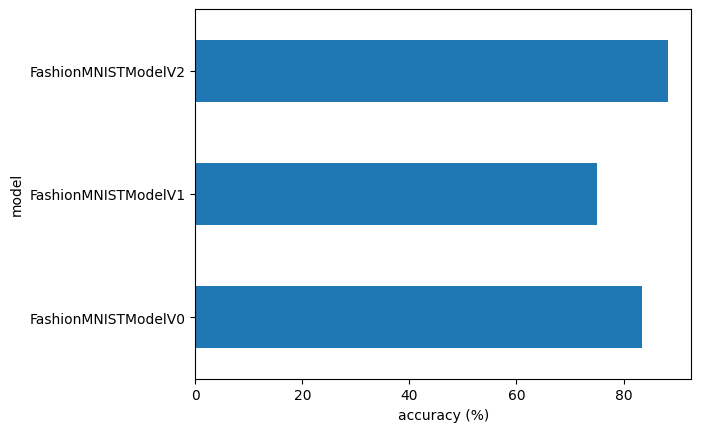

In [56]:
# Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model");

# Making predictions

In [59]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [61]:
import random
random.seed(42)

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [62]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model_2, 
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[1.2329e-08, 6.1216e-09, 8.0257e-09, 1.7877e-08, 2.9302e-09, 9.9993e-01,
         6.7611e-08, 9.8849e-06, 1.4758e-05, 4.7203e-05],
        [5.9152e-02, 6.2128e-01, 9.6286e-04, 2.1824e-01, 5.0734e-02, 2.0538e-05,
         4.9271e-02, 9.5579e-05, 2.1557e-04, 2.7187e-05]])

In [63]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

In [64]:
# Are our predictions in the same form as our test labels? 
test_labels, pred_classes

([5, 1, 7, 4, 3, 0, 4, 7, 1], tensor([5, 1, 7, 4, 3, 0, 4, 7, 1]))

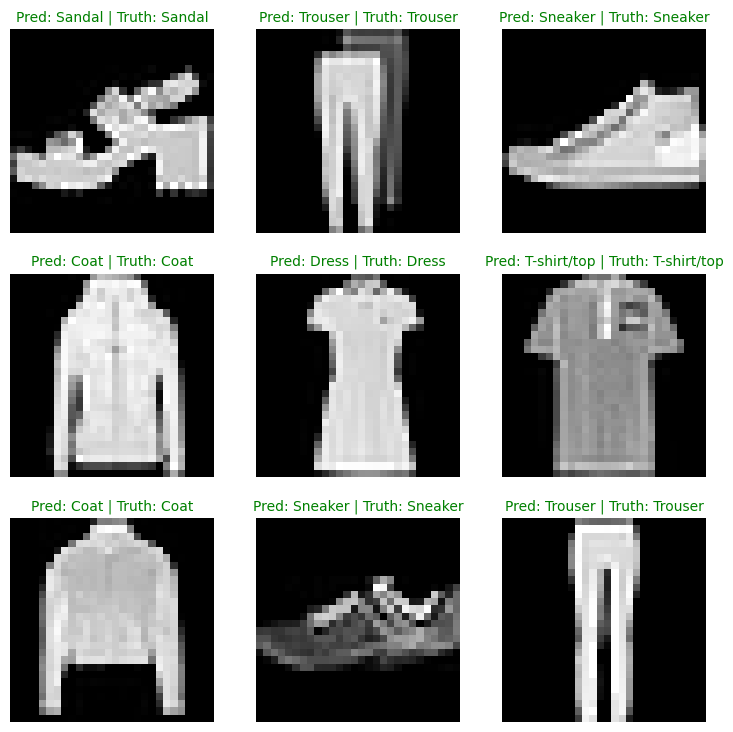

In [68]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);